In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!mkdir dataset

In [0]:
!mkdir data

In [0]:
!wget http://www.nada.kth.se/cvap/actions/boxing.zip
!wget http://www.nada.kth.se/cvap/actions/handclapping.zip
!wget http://www.nada.kth.se/cvap/actions/handwaving.zip
!wget http://www.nada.kth.se/cvap/actions/jogging.zip
!wget http://www.nada.kth.se/cvap/actions/running.zip
!wget http://www.nada.kth.se/cvap/actions/walking.zip
!wget http://www.nada.kth.se/cvap/actions/00sequences.txt -P dataset

!unzip boxing.zip -d dataset/boxing
!unzip handclapping.zip -d dataset/handclapping
!unzip handwaving.zip -d dataset/handwaving
!unzip jogging.zip -d dataset/jogging
!unzip running.zip -d dataset/running
!unzip walking.zip -d dataset/walking

!rm *.zip

In [6]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 102kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image
from scipy.misc.pilutil import imresize

## Global Variables

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]
IMG_W_ORIGINAL = 120
IMG_H_ORIGINAL = 160
IMG_W = 60
IMG_H = 80
CHANNELS = 1
SEQ_LEN = 30
SPACIALNET_INPUT_SHAPE = (SEQ_LEN, IMG_W, IMG_H, CHANNELS)
TEMPORALNET_INPUT_SHAPE = (SEQ_LEN-1, IMG_W//2, IMG_H//2, CHANNELS)
TEMPORALNET_INPUT_SHAPE_2x = (2 * (SEQ_LEN-1), IMG_W//2, IMG_H//2, CHANNELS)
NCLASSES = 6
EPOCHS = 50
BATCH_SIZE = 64

### Spliting Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading Dataset

In [10]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing dataset

### Extracting Optical Flow

In [0]:
def clean_sequence_file():
    print("Cleaning dataset/00sequences.txt ...")

    with open('dataset/00sequences.txt', 'r') as content_file:
      for _ in range(20):
        next(content_file)
      content = content_file.read()

    content = re.sub("[\t\n]", " ", content).split()

    frames_idx = {}

    current_filename = ""

    for s in content:
        if s == "frames":
            continue
        elif s.find("-") >= 0:
            if s[len(s) - 1] == ',':
                s = s[:-1]

            idx = s.split("-")

            if not current_filename in frames_idx:
                frames_idx[current_filename] = []
            frames_idx[current_filename].append((int(idx[0]), int(idx[1])))
        else:
            current_filename = s + "_uncomp.avi"

    return frames_idx

In [0]:
def extract_optflow(dataset="train"):
    if dataset == "train":
        ID = TRAIN_PEOPLE_ID
    elif dataset == "dev":
        ID = DEV_PEOPLE_ID
    else:
        ID = TEST_PEOPLE_ID

    # Setup parameters for optical flow.
    farneback_params = dict(
        winsize=10, iterations=1,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN, levels=2,
        pyr_scale=0.5, poly_n=5, poly_sigma=1, flow=None)

    frames_idx = clean_sequence_file()

    data = []

    for category in CATEGORIES:
        folder_path = os.path.join("", "dataset", category)
        filenames = sorted(os.listdir(folder_path))

        for filename in filenames:
            filepath = os.path.join("", "dataset", category, filename)

            person_id = int(filename.split("_")[0][6:])
            if person_id not in ID:
                continue

            vid = imageio.get_reader(filepath, "ffmpeg")

            flow_x = []
            flow_y = []

            prev_frame = None
            for i, frame in enumerate(vid):
                ok = False
                for seg in frames_idx[filename]:
                    if i >= seg[0] and i <= seg[1]:
                        ok = True
                        break
                if not ok:
                    continue

                # Convert to grayscale.
                frame = Image.fromarray(np.array(frame))
                frame = frame.convert("L")
                frame = np.array(frame.getdata(),
                                 dtype=np.uint8).reshape((IMG_W_ORIGINAL, IMG_H_ORIGINAL))
                frame = imresize(frame, (IMG_W, IMG_H))

                if prev_frame is not None:
                    # Calculate optical flow.
                    flows = cv2.calcOpticalFlowFarneback(prev_frame, frame,
                                                         **farneback_params)
                                        
                    # Subsampling optical flow by half (due to memory usage problems).
                    subsampled_x = np.zeros((IMG_W//2, IMG_H//2), dtype=np.float32)
                    subsampled_y = np.zeros((IMG_W//2, IMG_H//2), dtype=np.float32)
                    for r in range(IMG_W//2):
                        for c in range(IMG_H//2):
                            subsampled_x[r, c] = flows[r*2, c*2, 0]
                            subsampled_y[r, c] = flows[r*2, c*2, 1]

                    flow_x.append(subsampled_x)
                    flow_y.append(subsampled_y)

                prev_frame = frame

            data.append({
                "filename": filename,
                "category": category,
                "flow_x": flow_x,
                "flow_y": flow_y    
            })

    pickle.dump(data, open("data/%s_flow.p" % dataset, "wb"))

In [13]:
print("Extracting train optflow ...")
extract_optflow(dataset="train")
print("Extracting dev optflow ...")
extract_optflow(dataset="dev")
print("Extracting test optflow ...")
extract_optflow(dataset="test")

Extracting train optflow ...
Cleaning dataset/00sequences.txt ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Extracting dev optflow ...
Cleaning dataset/00sequences.txt ...
Extracting test optflow ...
Cleaning dataset/00sequences.txt ...


In [0]:
def read_ds(ds="train", separate_each_video=False):
  if(ds == "dev"):
    videos = dev_videos
    video_flows = pickle.load(open("data/dev_flow.p", "rb"))
  elif (ds == "test"):
    videos = test_videos
    video_flows = pickle.load(open("data/test_flow.p", "rb"))
  else:
    videos = train_videos
    video_flows = pickle.load(open("data/train_flow.p", "rb"))
      
  mean_frames = 0
  mean_flow_x = 0
  mean_flow_y = 0
    
  X = []
  y = []
  i=0
  X_per_video = []
  y_per_video = []
  print("total videos : %s" % len(videos))

  for video_index in range(len(videos)):
    seq_frame = []
    seq_flow_x = []
    seq_flow_y = []

    frames = videos[video_index]["frames"]
    flow_x = [0] + video_flows[video_index]["flow_x"]
    flow_y = [0] + video_flows[video_index]["flow_y"]

    for frame_index in range(len(frames)):
      seq_frame.append(frames[frame_index])

      if frame_index % SEQ_LEN > 0:
        seq_flow_x.append(flow_x[frame_index])
        seq_flow_y.append(flow_y[frame_index])

      if (frame_index + 1) % SEQ_LEN == 0:
        #print(seq_flow_x)
        seq_frame = np.array(seq_frame, dtype=np.float32).reshape(SPACIALNET_INPUT_SHAPE)
        seq_flow_x = np.array(seq_flow_x, dtype=np.float32).reshape(TEMPORALNET_INPUT_SHAPE)
        seq_flow_y = np.array(seq_flow_y, dtype=np.float32).reshape(TEMPORALNET_INPUT_SHAPE)

        mean_frames += np.mean(seq_frame)
        mean_flow_x += np.mean(seq_flow_x)
        mean_flow_y += np.mean(seq_flow_y)

        X.append({
            "frames": seq_frame,
            "flow_x": seq_flow_x,
            "flow_y": seq_flow_y
        })

        y.append(
            CATEGORIES.index(videos[video_index]["category"]))

        seq_frame = []
        seq_flow_x = []
        seq_flow_y = []


    if(separate_each_video):
      X_per_video.append(np.array(X))
      y_per_video.append(np.array(y, dtype=np.uint8))
      X = []
      y = []  
    
  mean_frames /= len(X)
  mean_flow_x /= len(X)
  mean_flow_y /= len(X)

  mean = {
      "frames": mean_frames,
      "flow_x": mean_flow_x,
      "flow_y": mean_flow_y
  }

  if(separate_each_video):
     return np.array(X_per_video), np.array(y_per_video), mean

  y = np.array(y, dtype=np.uint8)
  return X, y, mean

In [15]:
X_train_data, y_train, X_train_data_mean = read_ds(ds="train")
X_dev_data, y_dev, X_dev_data_mean = read_ds(ds="dev")
X_test_data, y_test, X_test_data_mean= read_ds(ds="test")

total videos : 191
total videos : 192
total videos : 216


In [16]:
X_test_average_prediction_data, y_test_per_video, X_test_average_prediction_data_mean= read_ds(ds="test", separate_each_video=True)

total videos : 216


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars


In [17]:
X_test_average_prediction_data.shape, len(X_test_data)

((216,), 2537)

In [0]:
def normalize_data(ds="train"):
  if(ds == "dev"):
    target_data = X_dev_data
    target_mean = X_dev_data_mean
  elif (ds == "test"):
    target_data = X_test_data
    target_mean = X_test_data_mean
  else:
    target_data = X_train_data
    target_mean = X_train_data_mean
  
  for i in range(len(target_data)):
    target_data[i]["frames"] -= float(target_mean["frames"])
    target_data[i]["flow_x"] -= float(target_mean["flow_x"])
    target_data[i]["flow_y"] -= float(target_mean["flow_y"])
  return target_data

In [0]:
X_train, train_flow_x, train_flow_y = np.array([ _['frames'] for _ in X_train_data]), np.array([ _['flow_x'] for _ in X_train_data]), np.array([ _['flow_y'] for _ in X_train_data])
X_dev, dev_flow_x, dev_flow_y = np.array([ _['frames'] for _ in X_dev_data]), np.array([ _['flow_x'] for _ in X_dev_data]), np.array([ _['flow_y'] for _ in X_dev_data])
X_test, test_flow_x, test_flow_y = np.array([ _['frames'] for _ in X_test_data]), np.array([ _['flow_x'] for _ in X_test_data]), np.array([ _['flow_y'] for _ in X_test_data])

In [20]:
X_train.shape, y_train.shape

((2397, 30, 60, 80, 1), (2397,))

In [21]:
train_flow_x.shape, y_train.shape

((2397, 29, 30, 40, 1), (2397,))

In [22]:
train_flow_y.shape, y_train.shape

((2397, 29, 30, 40, 1), (2397,))

In [23]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [0]:
def generate_sequences(ds="train", separate_each_video=False):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  X_per_video = []
  y_per_video = []
  
  for video in videos:

    frames = video["frames"]
    sequences = len(frames) // SEQ_LEN
    seq_frames = []
    sequnces_frames = [] 
    step = SEQ_LEN
    for i in range(0, len(frames)):
      if(i < step):
        seq_frames.append(frames[i])
      else:
        sequnces_frames.append(seq_frames)
        seq_frames = []
        step = step + SEQ_LEN + 1
    sequnces_frames = np.array(sequnces_frames[:sequences])
    for seq in sequnces_frames:
      X.append(seq.reshape(SPACIALNET_INPUT_SHAPE))
      y.append(CATEGORIES.index(video["category"]))

    if(separate_each_video):
      if(len(X_per_video) == 0) :
        X_per_video.append(np.array(X))      
        y_per_video.append(np.array(y))      
      else: 
        X_per_video.append(np.array(X))
        y_per_video.append(np.array(y))
        #y_per_video = cat((y_per_video, np.array(y)), axis=0)

      X = []
      y = []  

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)

  if(separate_each_video):
    return np.array(X_per_video), np.array(y_per_video)

  return X, y

In [25]:
X_test_average_prediction, y_test_average_prediction = generate_sequences( ds="test", separate_each_video=True)
X_test_average_prediction.shape, y_test_average_prediction.shape

((216,), (216,))

In [0]:
X_train_flow = np.concatenate((train_flow_x, train_flow_y), axis=0)
X_dev_flow = np.concatenate((dev_flow_x, dev_flow_y), axis=0)
X_test_flow = np.concatenate((test_flow_x, test_flow_y), axis=0)

In [27]:
train_flow_x.shape, X_train_flow.shape

((2397, 29, 30, 40, 1), (4794, 29, 30, 40, 1))

### Visualization Of The Data


In [0]:
import matplotlib.pyplot as plt

def show_images(images, cols = 1, titles = None):
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(16,12))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    #fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()


[412]
(1, 3, 30, 40, 1)
----------------------------------------------------------------------------------------------------
Grayscale Images : 


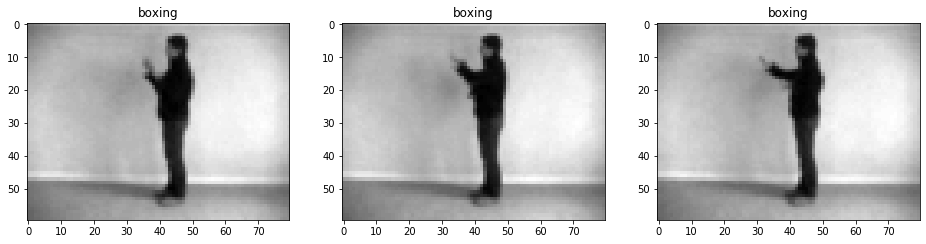

----------------------------------------------------------------------------------------------------
Farneback Flow x Images : 


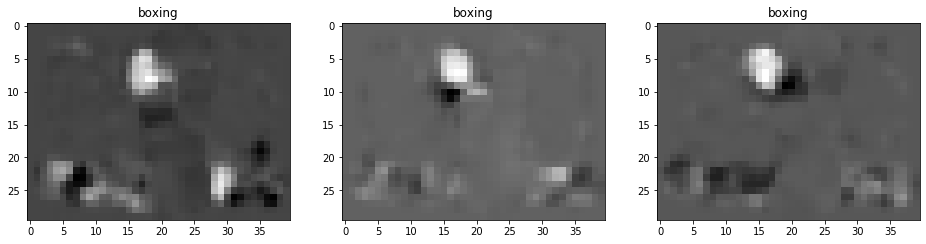

----------------------------------------------------------------------------------------------------
Farneback Flow y Images : 


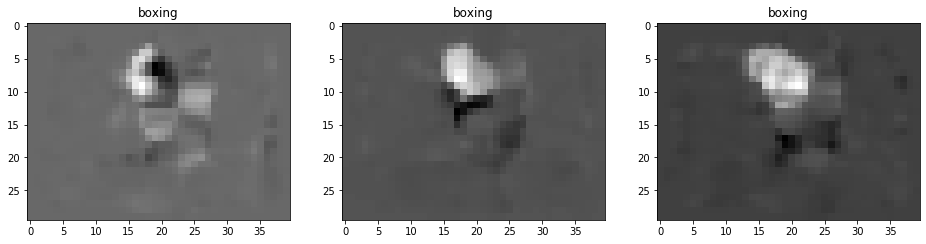

In [29]:
imgs_samples_size = 1
imgs_samples = np.random.randint(X_train.shape[0] - 1, size=imgs_samples_size)
imgs_per_samples = 3

imgs_gray_class = []
imgs_gray = []
imgs_flow_x = []
imgs_flow_y = []
for i in range(len(imgs_samples)):
  imgs_gray.append(X_train[imgs_samples[i]][0:SEQ_LEN:SEQ_LEN//imgs_per_samples])
  imgs_flow_x.append(train_flow_x[imgs_samples[i]][0:SEQ_LEN-1:SEQ_LEN//imgs_per_samples])
  imgs_flow_y.append(train_flow_y[imgs_samples[i]][0:SEQ_LEN-1:SEQ_LEN//imgs_per_samples])

#show_images(imgs_gray, cols = 1, titles = "Grayscale Images")

print(imgs_samples)
img_sample = imgs_samples[0]


print(np.array(imgs_flow_y).shape)
#plt.show(imgs_gray[img_sample].reshape(IMG_W, IMG_H))


reshaped_imgs_gray = []
reshaped_imgs_flow_x = []
reshaped_imgs_flow_y = []
for i in range(len(imgs_samples)):
  for j in range(len(imgs_gray[i])):
    imgs_gray_class.append(CATEGORIES[y_train[imgs_samples[i]]])
    reshaped_imgs_gray.append(imgs_gray[i][j].reshape(IMG_W, IMG_H))
    reshaped_imgs_flow_x.append(imgs_flow_x[i][j].reshape(IMG_W//2, IMG_H//2))
    reshaped_imgs_flow_y.append(imgs_flow_y[i][j].reshape(IMG_W//2, IMG_H//2))

print("-"*100)  
print("Grayscale Images : ")  
show_images(reshaped_imgs_gray, cols = imgs_samples_size, titles = imgs_gray_class)
print("-"*100)  
print("Farneback Flow x Images : ")  
show_images(reshaped_imgs_flow_x, cols = imgs_samples_size, titles = imgs_gray_class)
print("-"*100)  
print("Farneback Flow y Images : ")  
show_images(reshaped_imgs_flow_y, cols = imgs_samples_size, titles = imgs_gray_class)

## Preparing The Model

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import average, concatenate, Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add, GlobalAveragePooling1D
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

### Baseline Model

In [33]:
'''# CNN model (VGG like)
model = Sequential()

## Stage 2
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMG_W, IMG_H, CHANNELS)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 3
model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 4
model.add(Conv2D(128,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Output
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NCLASSES,activation='softmax'))'''

"# CNN model (VGG like)\nmodel = Sequential()\n\n## Stage 2\nmodel.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMG_W, IMG_H, CHANNELS)))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(32,(3,3),activation='relu',padding='valid'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2,2),padding='valid'))\n\n## Stage 3\nmodel.add(Conv2D(64,(3,3),activation='relu',padding='valid'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(64,(3,3),activation='relu',padding='valid'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2,2),padding='valid'))\n\n## Stage 4\nmodel.add(Conv2D(128,(3,3),activation='relu',padding='valid'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(128,(3,3),activation='relu',padding='valid'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2,2),padding='valid'))\n\n## Output\nmodel.add(Flatten())\nmodel.add(Dropout(0.5))\nmodel.add(Dense(256,activation='relu'))\nmodel.add(BatchNormalization())\nmode

In [0]:
def get_model(name, input_shape, get_feature_vector=True):
    # CNN model (VGG Action)
    inputs = Input(shape=input_shape)
    conv1_1 = Conv2D(32,(3,3),activation='relu', name='conv1_1_{}'.format(name))(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(32,(3,3),activation='relu',padding='same', name='conv1_2_{}'.format(name))(bn1_1)
    pool1_1 = MaxPooling2D(pool_size=(2,2),padding='valid', name='pool1_1_{}'.format(name))(conv1_2)

    conv2_1 = Conv2D(64,(3,3),activation='relu',padding='same', name='conv2_1_{}'.format(name))(pool1_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(64,(3,3),activation='relu',padding='same', name='conv2_2_{}'.format(name))(bn2_1)
    pool2_1 = MaxPooling2D(pool_size=(2,2),padding='valid', name='pool2_1_{}'.format(name))(conv2_2)

    conv3_1 = Conv2D(128,(3,3),activation='relu',padding='same', name='conv3_1_{}'.format(name))(pool2_1)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(128,(3,3),activation='relu',padding='same', name='conv3_2_{}'.format(name))(bn3_1)
    pool3_1 = MaxPooling2D(pool_size=(2,2),padding='valid', name='pool3_1_{}'.format(name))(conv3_2)

    flatten = Flatten()(pool3_1)
    dense4_1 = Dense(256,activation='relu', name='fc4_1_{}'.format(name))(flatten)
    dropout4_1 = Dropout(0.5)(dense4_1)
    bn4_1 = BatchNormalization()(dropout4_1)
    dropout4_2 = Dropout(0.5)(bn4_1)
    dense4_2 = Dense(512,activation='relu', name='fc4_2_{}'.format(name))(dropout4_2)

    if get_feature_vector:
      return dense4_2, inputs
    
    dropout4_3 = Dropout(0.5)(dense4_2)
    dense4_3 = Dense(NCLASSES, name='fc4_3_{}'.format(name))(dropout4_3)
    softmax = Activation('softmax')(dense4_3)

    return Model(inputs=inputs, outputs=softmax), inputs

In [0]:
def get_3dmodel(name, input_shape, get_feature_vector=True):
    # 3D CNN model (VGG Action)
    inputs = Input(shape=input_shape)
    conv1_1 = Conv3D(32,(1,3,3),activation='relu', name='conv1_1_{}'.format(name))(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv3D(32,(1,3,3),activation='relu',padding='same', name='conv1_2_{}'.format(name))(bn1_1)
    pool1_1 = MaxPooling3D(pool_size=(2,2,2),padding='valid', name='pool1_1_{}'.format(name))(conv1_2)

    conv2_1 = Conv3D(64,(1,3,3),activation='relu',padding='same', name='conv2_1_{}'.format(name))(pool1_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv3D(64,(1,3,3),activation='relu',padding='same', name='conv2_2_{}'.format(name))(bn2_1)
    pool2_1 = MaxPooling3D(pool_size=(2,2,2),padding='valid', name='pool2_1_{}'.format(name))(conv2_2)

    conv3_1 = Conv3D(128,(1,3,3),activation='relu',padding='same', name='conv3_1_{}'.format(name))(pool2_1)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv3D(128,(1,3,3),activation='relu',padding='same', name='conv3_2_{}'.format(name))(bn3_1)
    pool3_1 = MaxPooling3D(pool_size=(2,2,2),padding='valid', name='pool3_1_{}'.format(name))(conv3_2)

    flatten = Flatten()(pool3_1)
    dense4_1 = Dense(256,activation='relu', name='fc4_1_{}'.format(name))(flatten)
    dropout4_1 = Dropout(0.5)(dense4_1)
    bn4_1 = BatchNormalization()(dropout4_1)
    dropout4_2 = Dropout(0.5)(bn4_1)
    dense4_2 = Dense(512,activation='relu', name='fc4_2_{}'.format(name))(dropout4_2)

    if get_feature_vector:
      return dense4_2, inputs
    
    dropout4_3 = Dropout(0.5)(dense4_2)
    dense4_3 = Dense(NCLASSES, name='fc4_3_{}'.format(name))(dropout4_3)
    softmax = Activation('softmax')(dense4_3)

    return Model(inputs=inputs, outputs=softmax), inputs

### Model Fusions

In [0]:
spatial_net, spatial_input = get_3dmodel(name='spatial_net', input_shape=SPACIALNET_INPUT_SHAPE, get_feature_vector=False)
temporal_net, temporal_input = get_3dmodel(name='temporal_net', input_shape=TEMPORALNET_INPUT_SHAPE_2x, get_feature_vector=False)

inputs = [spatial_net.input, temporal_net.input]
outputs = average([spatial_net.output, temporal_net.output])
model = Model(inputs, outputs)

In [57]:
train_spatial_data = X_train
train_temporal_data = np.concatenate((train_flow_x, train_flow_y), axis=1)

dev_spatial_data = X_dev
dev_temporal_data = np.concatenate((dev_flow_x, dev_flow_y), axis=1)

test_spatial_data = X_test
test_temporal_data = np.concatenate((test_flow_x, test_flow_y), axis=1)

train_spatial_data.shape, train_temporal_data.shape

((2397, 30, 60, 80, 1), (2397, 58, 30, 40, 1))

In [58]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 30, 60, 80, 1 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 58, 30, 40, 1 0                                            
__________________________________________________________________________________________________
conv1_1_spatial_net (Conv3D)    (None, 30, 58, 78, 3 320         input_5[0][0]                    
__________________________________________________________________________________________________
conv1_1_temporal_net (Conv3D)   (None, 58, 28, 38, 3 320         input_6[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##Training The Model

In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=25)
]

In [61]:
trained_model = model.fit([train_spatial_data, train_temporal_data], y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=([dev_spatial_data, dev_temporal_data], y_dev), callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2397 samples, validate on 2332 samples
Epoch 1/50





2397/2397 [==============================] - 60s 25ms/step - loss: 1.4744 - acc: 0.4147 - val_loss: 1.0430 - val_acc: 0.6295
Epoch 2/50
2397/2397 [==============================] - 37s 15ms/step - loss: 0.9410 - acc: 0.6554 - val_loss: 0.7648 - val_acc: 0.7191
Epoch 3/50
2397/2397 [==============================] - 37s 15ms/step - loss: 0.7585 - acc: 0.7376 - val_loss: 0.6935 - val_acc: 0.7762
Epoch 4/50
2397/2397 [==============================] - 37s 15ms/step - loss: 0.6150 - acc: 0.7952 - val_loss: 0.6858 - val_acc: 0.7264
Epoch 5/50
2397/2397 [==============================] - 37s 15ms/step - loss: 0.5423 - acc: 0.8269 - val_loss: 0.6720 - val_acc: 0.7817
Epoch 6/50
2397/2397 [==============================] - 37s 15ms/step - loss: 0.4608 - acc: 0.8419 - val_loss: 0.7946 - val_acc: 0.7560
Epoch 7/50
2397/2397 [============

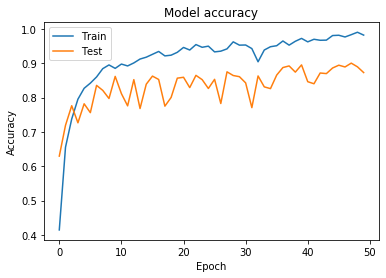

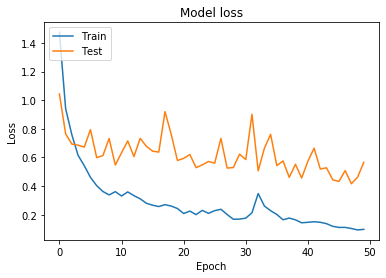

In [62]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Evaluating The Model
### 1) Simple Evaluation 


In [117]:
model.evaluate([test_spatial_data, test_temporal_data], y_test)

2537/2537 [==============================] - 10s 4ms/step


[0.5672025045639005, 0.8352384706346078]

### 2) Average Prediction Evaluation

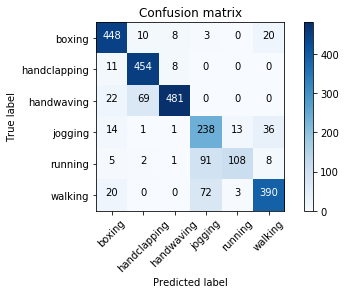

In [118]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
Y_pred = model.predict([test_spatial_data, test_temporal_data])
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [0]:
preds = np.array([])
pred_y = []
i = 0

for video_seq_index in range(len(X_test_average_prediction_data)):
  X_test_avg, test_avg_flow_x, test_avg_flow_y = np.array([ _['frames'] for _ in X_test_average_prediction_data[video_seq_index]]), np.array([ _['flow_x'] for _ in X_test_average_prediction_data[video_seq_index]]), np.array([ _['flow_y'] for _ in X_test_average_prediction_data[video_seq_index]])
  y_per_vid = np.array([])
  X_test_flow_avg = np.concatenate((test_avg_flow_x, test_avg_flow_y), axis=1)
  p = model.predict([X_test_avg, X_test_flow_avg])
  results = np.array(p).mean(axis=0)
  index = np.argmax(results)
  label = CATEGORIES[index]
  pred_y.append(index)
  preds = np.append(preds, p)
  i+=1

pred_y = np.array(pred_y, dtype=np.str)

In [120]:
y_test_average_prediction[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
y_test_per_video_classes = []
y_test_per_video_seq = y_test_average_prediction

y_test_per_video = []
for y in y_test_per_video_seq:
  y_test_per_video.append(to_categorical(y[0]))
  y_test_per_video_classes.append(y[0])
y_test_per_video_classes = np.array(y_test_per_video_classes, dtype=np.str)

In [122]:
y_test_per_video_classes.shape, pred_y.shape

((216,), (216,))

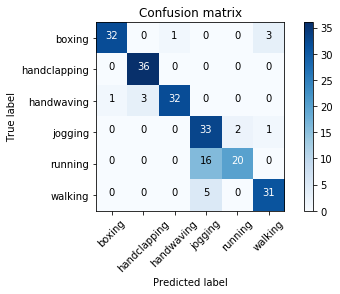

In [123]:
confusion_mtx = confusion_matrix(y_test_per_video_classes, pred_y) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [124]:
i=0
acc=0
for y in pred_y:
  if(y == y_test_per_video_classes[i]):
    acc+=1
  i+=1
accuracy = acc / len(pred_y)
print("Average Prediction Accuracy : %s" % accuracy)

Average Prediction Accuracy : 0.8518518518518519


### 3) Max Prediction Evaluation

In [0]:
preds = np.array([])
pred_y = []
i = 0

for video_seq_index in range(len(X_test_average_prediction_data)):
  X_test_avg, test_avg_flow_x, test_avg_flow_y = np.array([ _['frames'] for _ in X_test_average_prediction_data[video_seq_index]]), np.array([ _['flow_x'] for _ in X_test_average_prediction_data[video_seq_index]]), np.array([ _['flow_y'] for _ in X_test_average_prediction_data[video_seq_index]])
  y_per_vid = np.array([])
  X_test_flow_avg = np.concatenate((test_avg_flow_x, test_avg_flow_y), axis=1)
  p = model.predict([X_test_avg, X_test_flow_avg])
  results = np.array(p).max(axis=0)
  index = np.argmax(results)
  label = CATEGORIES[index]
  pred_y.append(index)
  preds = np.append(preds, p)
  i+=1

pred_y = np.array(pred_y, dtype=np.str)

In [0]:
y_test_per_video_classes = []
y_test_per_video_seq = y_test_average_prediction

y_test_per_video = []
for y in y_test_per_video_seq:
  y_test_per_video.append(to_categorical(y[0]))
  y_test_per_video_classes.append(y[0])
y_test_per_video_classes = np.array(y_test_per_video_classes, dtype=np.str)

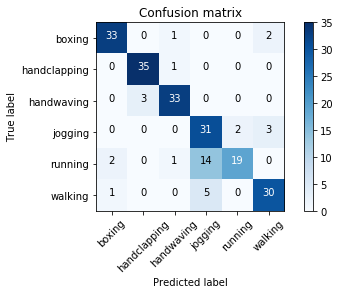

In [127]:
confusion_mtx = confusion_matrix(y_test_per_video_classes, pred_y) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [128]:
i=0
acc=0
for y in pred_y:
  if(y == y_test_per_video_classes[i]):
    acc+=1
  i+=1
accuracy = acc / len(pred_y)
print("Max Prediction Accuracy : %s" % accuracy)

Max Prediction Accuracy : 0.8379629629629629


##Saving The Model 

In [0]:
model.save_weights('2Stream_KTH.h5')

In [0]:
plot_model(model, show_shapes=True, to_file='2Stream_KTH.png')